<a href="https://colab.research.google.com/github/PARULCHUTANIPC/parul/blob/Paper-2/dogs%26cats%20cnn%20%2B%20svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install kaggle

from zipfile import ZipFile
import io, cv2, fnmatch, shutil, os, getpass, subprocess, random

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from time import time
from glob import glob
from sklearn.utils import class_weight
from google.colab import files

In [3]:
root_dir = '/content'
download_dir = os.path.join(root_dir,'cats_dogs')
data_dir = os.path.join(download_dir,'data')
train_path = os.path.join(data_dir,'train')
val_path = os.path.join(data_dir,'val')
train_dogs_path = os.path.join(train_path,'dogs')
train_cats_path = os.path.join(train_path,'cats')
val_dogs_path = os.path.join(val_path,'dogs')
val_cats_path = os.path.join(val_path,'cats')

data source - https://www.kaggle.com/c/dogs-vs-cats/data

In [4]:
!pip install kaggle

In [5]:
!mkdir .kaggle
!touch .kaggle/kaggle.json

In [6]:
os.environ['KAGGLE_CONFIG_DIR'] = root_dir
os.chdir(root_dir)
if 'kaggle.json' not in os.listdir(root_dir):downloaded = files.upload()
if 'cats_dogs' in os.listdir(root_dir):shutil.rmtree(download_dir)
os.mkdir(download_dir)
os.chdir(download_dir)
!kaggle competitions download -c dogs-vs-cats
!unzip -q -o train.zip
!unzip -q -o test1.zip

Saving kaggle.json to kaggle.json
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 33.1MB/s]
 99% 536M/543M [00:02<00:00, 227MB/s]
100% 543M/543M [00:02<00:00, 217MB/s]
 94% 256M/271M [00:01<00:00, 212MB/s]
100% 271M/271M [00:01<00:00, 172MB/s]


In [7]:
cat_pattern = '*cat.*.jpg'
dog_pattern = '*dog.*.jpg'

images = glob('/content/cats_dogs/train/*.jpg', recursive=True)
cats = fnmatch.filter(images,cat_pattern)
dogs = fnmatch.filter(images,dog_pattern)

if 'data' not in os.listdir(download_dir):os.mkdir(data_dir)
if 'train' not in os.listdir(data_dir):os.mkdir(train_path)
if 'dogs' not in os.listdir(train_path):os.mkdir(train_dogs_path)
if 'cats' not in os.listdir(train_path):os.mkdir(train_cats_path)
  
if 'val' not in os.listdir(data_dir):os.mkdir(val_path)
if 'dogs' not in os.listdir(val_path):os.mkdir(val_dogs_path)
if 'cats' not in os.listdir(val_path):os.mkdir(val_cats_path)

for file in cats: shutil.copy2(file, train_cats_path)
for file in dogs: shutil.copy2(file, train_dogs_path)
  
  
# split train date into train and validation
train_len = len(os.listdir(train_dogs_path))
val_len = train_len * 0.3
val_dogs = random.sample(os.listdir(train_dogs_path),int(val_len))
val_cats = random.sample(os.listdir(train_cats_path),int(val_len))

for file in val_dogs:
  try: shutil.move(os.path.join(train_dogs_path,file), val_dogs_path)
  except: pass
for file in val_cats:
  try: shutil.move(os.path.join(train_cats_path,file), val_cats_path)
  except: pass
  
print(len(os.listdir(train_cats_path)))
print(len(os.listdir(val_cats_path)))

print(len(os.listdir(train_dogs_path)))
print(len(os.listdir(val_dogs_path)))

print('total train samples ', len(os.listdir(train_cats_path)) + len(os.listdir(train_dogs_path)))
print('total train samples ', len(os.listdir(val_cats_path)) + len(os.listdir(val_dogs_path)))

8750
3750
8750
3750
total train samples  17500
total train samples  7500


#CNN classifier

In [17]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size=64
train_generator = train_datagen.flow_from_directory(
        '/content/cats_dogs/data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary') 

validation_generator = val_datagen.flow_from_directory(
        '/content/cats_dogs/data/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
# cnn_model.add(Conv2D(64, (5, 5), input_shape = (28,28,1), activation='relu'))
# cnn_model.add(layers.MaxPooling2D(pool_size = (2, 2)))
# cnn_model.add(Dropout(0.25))

model = Sequential()

#model.add(Conv2D(150, (3, 3), input_shape=( 150, 150, 3)))
# model.add(Activation('relu'))

model.add(Conv2D(150,(3,3),input_shape = (150,150,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(200,(3,3),input_shape = (150,150,3), activation = 'relu'))
# model.add(Conv2D(200, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(215,(3,3),input_shape = (150,150,3), activation = 'relu'))
# model.add(Conv2D(215, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Conv2D(190,(3,3),input_shape = (150,150,3), activation = 'relu'))
# model.add(Conv2D(190, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(140,(3,3),input_shape = (150,150,3), activation = 'relu'))
# model.add(Conv2D(190, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))

# # Step 5 - Output Layer
# #cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
# ## For Binary Classification
# cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
#              ='linear'))

model.add(Flatten()) 
model.add(Dense(units=1, activation='sigmoid'))

# dense = tf.keras.layers.Dense(3, kernel_regularizer='l2')


# # model.add(Dense(1, kernel_regularizer=l2(0.01)))
                # l2(0.01),activation='linear'))



# #model.add(Dense(340))
# model.add(Activation('relu'))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))



Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [27]:
## for mulitclassification

model.add(Dense(1, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform', 
                kernel_regularizer='l2', bias_regularizer=None))
# model.add(Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
#              ='softmax'))
model.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['accuracy'])

In [28]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 148, 148, 150)     4200      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 74, 74, 150)       0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 74, 74, 150)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 72, 72, 200)       270200    
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 36, 36, 200)       0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 36, 36, 200)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 34, 34, 215)      

In [75]:
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
r=model.fit(x = train_generator, validation_data = validation_generator, epochs = 20)

Epoch 1/20
274/274 [==============================] - 144s 522ms/step - loss: 0.9963 - accuracy: 0.5026 - val_loss: 1.0001 - val_accuracy: 0.5000
Epoch 2/20
274/274 [==============================] - 143s 520ms/step - loss: 0.9973 - accuracy: 0.5014 - val_loss: 1.0000 - val_accuracy: 0.5000
Epoch 3/20
274/274 [==============================] - 142s 519ms/step - loss: 1.0047 - accuracy: 0.4977 - val_loss: 1.0000 - val_accuracy: 0.5000
Epoch 4/20
274/274 [==============================] - 141s 516ms/step - loss: 0.9900 - accuracy: 0.5050 - val_loss: 1.0000 - val_accuracy: 0.5000
Epoch 5/20
274/274 [==============================] - 141s 515ms/step - loss: 1.0020 - accuracy: 0.4990 - val_loss: 1.0000 - val_accuracy: 0.5000
Epoch 6/20
274/274 [==============================] - 141s 516ms/step - loss: 1.0101 - accuracy: 0.4950 - val_loss: 1.0000 - val_accuracy: 0.5000
Epoch 7/20
274/274 [==============================] - 142s 519ms/step - loss: 1.0024 - accuracy: 0.4988 - val_loss: 1.0000 -

In [34]:
import matplotlib.pyplot as plt

In [53]:

print(train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [54]:
test_images, test_labels = next(validation_generator)
#imgs, labels = next(train_generator)

In [55]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

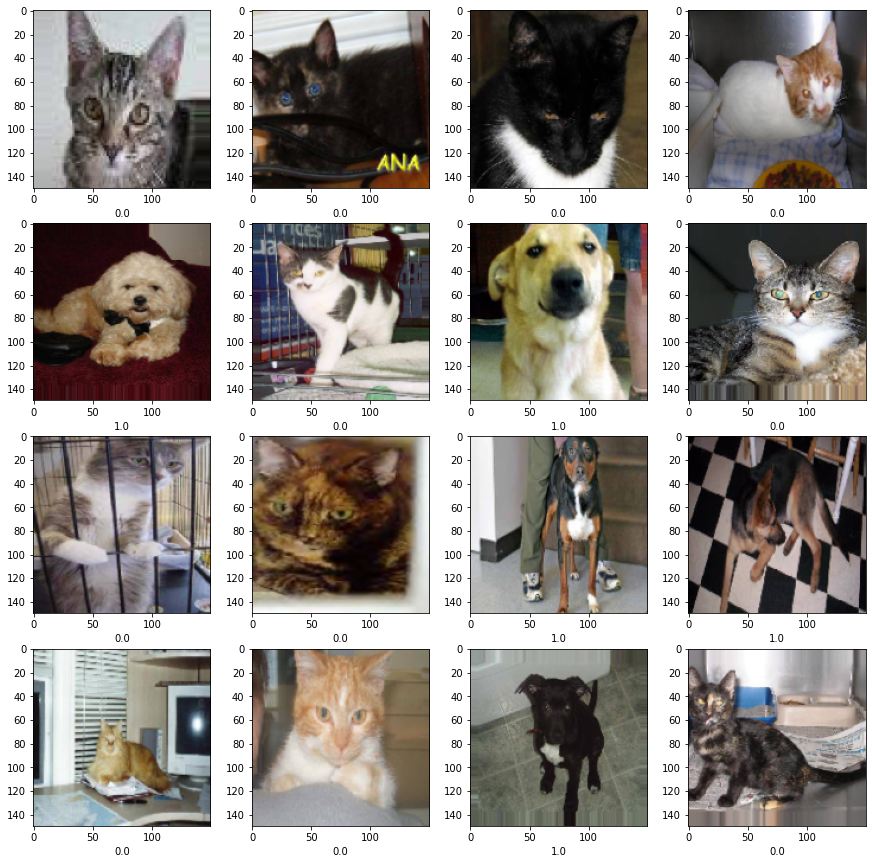

In [74]:
train_images,train_labels = train_generator.next()
plt.figure(figsize=(15,15))
# print(len(train_images))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])

274


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:706: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = np.array(x, subok=True, copy=copy)


ValueError: ignored

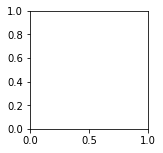

In [39]:
plt.figure(figsize=(10,10))
# for i in range(9):
#   plt.subplot(3,3,i+1)
#   plt.imshow(train_images[i])
#   plt.xlabel(class_names[train_labels[i]])
# train_images,train_labels = train_generator.next()

print(len(train_generator))
for i in range(0,len(train_generator)):
  plt.subplot(4,4,i+1)
  image = train_generator[i]
  # print(train_labels[i], " random images from the training dataset")
  plt.imshow(image)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

start_time = time()
model.fit_generator(
        train_generator,
        #steps_per_epoch=18631 // batch_size,
        epochs=25,
        validation_data=validation_generator,
        #validation_steps=10119 // batch_size
        )
model.save_weights('first_try.h5')

print('time taken ',time()-start_time)

#Transfer learning

In [ ]:
#BASE_MODEL = 'VGG16'
from keras.preprocessing.image import ImageDataGenerator

def transfer_learning(BASE_MODEL):
  if BASE_MODEL=='VGG16':
      from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
  elif BASE_MODEL=='vgg19':
      from keras.applications.vgg19 import VGG19 as PTModel, preprocess_input
  elif BASE_MODEL=='ResNet50':
      from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
  elif BASE_MODEL=='InceptionV3':
      from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
  elif BASE_MODEL=='Xception':
      from keras.applications.xception import Xception as PTModel, preprocess_input
  elif BASE_MODEL=='DenseNet169': 
      from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
  elif BASE_MODEL=='DenseNet121':
      from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
  else:
      raise ValueError('Unknown model: {}'.format(BASE_MODEL))
  
  import keras
  keras.backend.set_learning_phase(1)
  
  check_point_name = BASE_MODEL + '.model'
  model_weights = BASE_MODEL + '.h5'

  train_datagen = ImageDataGenerator(
          rescale=1./255,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          preprocessing_function = preprocess_input)

  val_datagen = ImageDataGenerator(rescale=1./255,
                                  preprocessing_function = preprocess_input)

  batch_size=32
  train_generator = train_datagen.flow_from_directory(
          '/content/cats_dogs/data/train',  # this is the target directory
          target_size=(250, 250),  # all images will be resized to 150x150
          batch_size=batch_size,
          class_mode='binary') 

  validation_generator = val_datagen.flow_from_directory(
          '/content/cats_dogs/data/val',
          target_size=(250, 250),
          batch_size=batch_size,
          class_mode='binary')    

  img_rows, img_cols, img_channel = 250, 250, 3
  base_model = PTModel(weights='imagenet'
                     ,include_top=False, input_shape=(img_rows, img_cols, img_channel), classes = 2)

  add_model = Sequential()
  add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
  add_model.add(Dense(64, activation='relu'))
  add_model.add(Dense(1, activation='sigmoid'))

  model = Model(inputs=base_model.input, outputs=add_model(base_model.output))


  for layer in base_model.layers:
      layer.trainable = False

      if layer.name.startswith('bn'):
          layer.call(layer.input, training=False)


  model.compile(loss='binary_crossentropy', optimizer=SGD(lr=1e-4, momentum=0.9),
                metrics=['accuracy'])
  start_time = time()
  model.fit_generator(
          train_generator,
          epochs=16,
          validation_data=validation_generator,
          #class_weight = class_weights,
          callbacks=[ModelCheckpoint(check_point_name, monitor='val_acc', save_best_only=True)])
  model.save_weights(model_weights)

  print('time taken ',time()-start_time)

In [ ]:
transfer_learning('VGG16')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
58892288/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/16
547/547 [==============================] - 382s 686ms/step - loss: 0.5134 - accuracy: 0.7450 - val_loss: 0.2836 - val_accuracy: 0.8903
Epoch 2/16
547/547 [==============================] - 369s 674ms/step - loss: 0.2856 - accuracy: 0.8861 - val_loss: 0.2221 - val_accuracy: 0.9137
Epoch 3/16
547/547 [==============================] - 368s 673ms/step - loss: 0.2358 - accuracy: 0.9093 - val_loss: 0.2043 - val_accuracy: 0.9189
Epoch 4/16
547/547 [==============================] - 366s 670ms/step - loss: 0.2152 - accuracy: 0.9163 - val_loss: 0.2001 - val_accuracy: 0.9192
Epoch 5/16
547/547 [==============================] - 366s 668ms/step - loss: 0.2038 - accuracy: 0.9216 - val_loss: 0.1992 - val_accuracy: 0.9112
Epoch 6/16
547/547 [==============================] - 367s 671ms/step - loss: 0.1880 - accuracy: 0.9271 - val_loss: 0.1754 - val_accuracy: 0.9301
Epoch 7/16
547/547 [==============================] - 367s 671ms/step - loss: 0.1793 - accuracy: 0.9295 - val_loss: 0.1663 -

In [ ]:
transfer_learning('DenseNet169')

In [ ]:
transfer_learning('vgg19')

In [ ]:
transfer_learning('InceptionV3')

In [ ]:
# running on TPU

# !pip install keras==2.1
# import tensorflow as tf
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense


BASE_MODEL = 'VGG16'

from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='vgg19':
    from keras.applications.vgg19 import VGG19 as PTModel, preprocess_input
elif BASE_MODEL=='ResNet50':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))
    
    
import keras
keras.backend.set_learning_phase(1)
    
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function = preprocess_input)

val_datagen = ImageDataGenerator(rescale=1./255,
                                preprocessing_function = preprocess_input)

batch_size=32
train_generator = train_datagen.flow_from_directory(
        '/content/cats_dogs/data/train',  # this is the target directory
        target_size=(200, 200),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary') 

validation_generator = val_datagen.flow_from_directory(
        '/content/cats_dogs/data/val',
        target_size=(200, 200),
        batch_size=batch_size,
        class_mode='binary')    

img_rows, img_cols, img_channel = 200, 200, 3
base_model = PTModel(weights='imagenet'
                   ,include_top=False, input_shape=(img_rows, img_cols, img_channel), classes = 2)

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(64, activation='relu'))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))


for layer in base_model.layers:
    layer.trainable = False
    
    if layer.name.startswith('bn'):
        layer.call(layer.input, training=False)
    
    
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

tpu_model.compile(loss='binary_crossentropy'
              ,optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

start_time = time()
model.fit_generator(
        train_generator,
        epochs=16,
        validation_data=validation_generator
        #class_weight = class_weights,
        ,callbacks=[ModelCheckpoint('Xception-transferlearning.model', monitor='val_acc', save_best_only=True)]
        )
model.save_weights('Xception.h5')

print('time taken ',time()-start_time)

## Evaluation and Visualizing the Output

In [ ]:
evaluation = model.evaluate(test_images, test_labels)
print(f'Test Accuracy : {evaluation[1]:.3f}')

In [ ]:
# get the predictions for the test data
predicted_classes = model.predict_classes(test_images)
predicted_classes

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize = (14,10))
sns.heatmap(cm, cmap ="YlGnBu", annot= True )

In [ ]:
cm

In [ ]:
from sklearn.metrics import classification_report

num_classes = 10
target_names = [f"Class {i}" for i in range(num_classes)]

print(classification_report(test_labels, predicted_classes, target_names = target_names))

In [ ]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
xc=range(70)

In [ ]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss, 'r')
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs test_loss', )
plt.grid(True)
plt.legend(['train','test'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [ ]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc,'r')
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])